### Dependencies

In [44]:
def get_f_period(p_date,f_date):
    d = pd.to_datetime(p_date) - pd.to_datetime(f_date)
    return d.days * 24  + d.seconds // 3600

import os 
import pickle
import pandas as pd
import numpy as np
import xgboost

### Load Data 
- Last Measurements (from 01/03/2021)
- Last 5 months of Forecasts

In [45]:
# Measurements
measurement_out = pd.read_csv('../data/processed/last_measurement.csv')
measurement_out['datetime'] = measurement_out['datetime'].map(lambda x : pd.to_datetime(x)) 
# Forecasts
forecast = pd.read_csv('../data/processed/last_forecast.csv')
forecast['f_date'] = forecast['f_date'].map(lambda x : pd.to_datetime(x))
forecast['p_date'] = forecast['p_date'].map(lambda x : pd.to_datetime(x))
forecast['file_creation_date'] = forecast['file_creation_date'].map(lambda x : pd.to_datetime(x))

### Data Processing
- Shift measurements to get 49 lag
- Data Merge 
- Keep last forecasts

In [46]:
### Data Merge ###

# Save a copy of measurements to score results
Y_real = measurement_out.copy()

# 49 lag of measurements horizontal stack 
df_out = Y_real.add_suffix('_t-0')
for i in range(1, 49):
    df_temp = Y_real.copy().add_suffix('_t-'+str(i))
    df_out = pd.concat([df_out,df_temp.shift(i)],axis=1)
df_out = df_out.dropna(how='any')
#display(df_out.head(1))

# join measurements & forecast
df_joined = df_out.copy()
df_joined = df_joined.merge(forecast.add_suffix('_forecast'),
                 how='left',
                 left_on = 'datetime_t-0',
                 right_on='f_date_forecast')

# filter forecast files created after prediction time (same as crop out f_period > 7)
df_joined = df_joined.loc[df_joined['datetime_t-0'] >= df_joined['file_creation_date_forecast'],]


# Compute f_period
df_joined['f_period'] = df_joined[['datetime_t-0','p_date_forecast']] \
                         .apply(lambda row : get_f_period(row['datetime_t-0'],row['p_date_forecast']),axis=1)

# assert that file_creation_date_forecast is doing the job
assert((df_joined.f_period > 7).any()) 

# keep last forecast
df_joined = df_joined.groupby('datetime_t-0')['f_period'].min().reset_index() \
             .merge(df_joined,how='left')
    
# compute cos day and hour 
df_joined['cos_day'] = np.cos(2 * np.pi * df_joined['datetime_t-0'].dt.day / 365)
df_joined['cos_hour'] =  np.cos(2 * np.pi * df_joined['datetime_t-0'].dt.hour / 24)
#display(df_joined.head(1))

### New models adjustements
- Compute forecast scenario & Dangerous
- Rename f_period -> f_period_forecast

In [47]:
# Compute needed columns for updated models
def get_int_scenario(speed, cos, sin):
    if is_S1(speed, cos, sin):
        return 1
    elif is_S2(speed, cos, sin):
        return 2
    elif is_S2b(speed, cos, sin):
        return 3
    elif is_S3(speed, cos, sin):
        return 4
    elif is_S3b(speed, cos, sin):
        return 5
    elif is_S4(speed, cos, sin):
        return 6
    return np.nan

import sys
sys.path.append('../')
from utils.ui import *

df_joined['scenario_forecast'] = df_joined.apply(lambda row : get_int_scenario(row['speed_forecast'],
                                             row['cos_wind_dir_forecast'],
                                             row['sin_wind_dir_forecast']),
                  axis=1)

df_joined['dangerous_forecast'] = (df_joined['scenario_forecast'] > 3 ).map(int)

df_joined = df_joined.rename(columns={'f_period':'f_period_forecast'})

### Make predictions
- Load all models (regression & classification
- Merge predictions : model_feature_lag (prediction date is shifted to align with measurement t-0)

In [48]:
# To render results on app we need a branch here for datetime shift ###
from datetime import timedelta

# Load needed columns for all models 
columns_names = list(pd.read_csv('../models_09072021/column_names.csv')['0'])

# Loop lists
model_names = ['xgb','dt','mlp','rf']
features = ['speed','cos_wind_dir','sin_wind_dir','scenario','dangerous']
pred_periods = ['1','2','3']


models = dict()
for model_name in model_names:
    for feature in features:
        for pred_period in pred_periods:
            x = '_'.join([model_name,feature,pred_period])
            # Load model
            models[x] = pickle.load(open('../models_09072021/trained_models/' + x + '.pkl','rb'))
            df_temp = df_joined[['datetime_t-0']].copy()
            # Shift date
            df_temp['datetime_t-0'] = df_temp['datetime_t-0'] + timedelta(hours=int(pred_period))
            # Predict
            try:
                assert(feature == 'dangerous')
                df_temp[x] = models[x].predict_proba(df_joined[columns_names])[:,1]
                print(x)
            except:
                df_temp[x] = models[x].predict(df_joined[columns_names])
            # Save
            df_joined = df_joined.merge(df_temp,how='left')
            del df_temp

# Drop missing values (at least the 3 first rows)
df_joined = df_joined.dropna()
df_joined.shape

xgb_dangerous_1
xgb_dangerous_2
xgb_dangerous_3
dt_dangerous_1
dt_dangerous_2
dt_dangerous_3
mlp_dangerous_1
mlp_dangerous_2
mlp_dangerous_3
rf_dangerous_1
rf_dangerous_2
rf_dangerous_3


(3451, 467)

(array([3.118e+03, 1.450e+02, 2.300e+01, 4.200e+01, 4.900e+01, 3.000e+00,
        9.000e+00, 2.700e+01, 1.900e+01, 1.600e+01]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

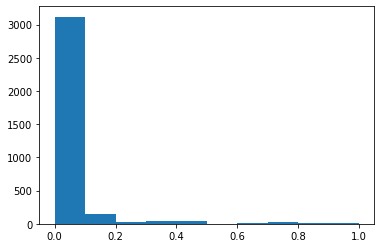

In [50]:
import matplotlib.pyplot as plt
plt.hist(df_joined['dt_dangerous_2'])

### Speed regression mae

In [51]:
from sklearn.metrics import mean_absolute_error

### Speed Mae ###
print('Model   1   2   3')
for model in ['xgb','rf','dt','mlp']:
    print(model,
          round(mean_absolute_error(df_joined['speed_t-0'],df_joined[model + '_speed_1']),2),
          round(mean_absolute_error(df_joined['speed_t-0'],df_joined[model + '_speed_2']),2),
          round(mean_absolute_error(df_joined['speed_t-0'],df_joined[model + '_speed_3']),2)
         )
print('Numtech' , round(mean_absolute_error(df_joined['speed_t-0'],df_joined['speed_forecast']),2))

Model   1   2   3
xgb 0.5 0.76 0.94
rf 0.54 0.83 1.04
dt 0.56 0.84 1.07
mlp 0.55 0.78 0.91
Numtech 1.04


### Wind Direction Regression Mae

In [52]:
def get_angle_in_degree(cos, sin):
    #check if cos within reasonable range: 
    if (cos>=-1) & (cos <=1): 
        angle = 360 * np.arccos(cos) / (2*np.pi)
        if sin < 0:
            angle = 360 - angle
    #check if sin within reasonable range:       
    elif (sin>=-1) & (sin <=1):
        angle = 360 * np.arcsin(sin) / (2*np.pi)
        if cos < 0:
            angle = 180 - angle
        if angle < 0:
            angle += 360
    else:
        angle=0 
        #print('cos and sin out of range, returned 0')
    #because we care about the reverse angle for the scenarios
    return angle #(angle + 180) % 360

def angle_diff(x):
    if x <= 180:
        return x 
    else:
        return 360-180
    

### Real wind dir ###
df_joined['wind_dir_t-0'] =  df_joined.apply(lambda row : get_angle_in_degree(row['cos_wind_dir_t-0'],
                                                                              row['sin_wind_dir_t-0']),
                                             axis=1)
    
for model_name in model_names:
    for pred_period in pred_periods:
        input_cos = model_name + '_cos_wind_dir_' + pred_period
        input_sin = model_name + '_sin_wind_dir_' + pred_period
        output_wind_dir = model_name + '_wind_dir_' + pred_period
        df_joined[output_wind_dir] =  df_joined.apply(lambda row : get_angle_in_degree(row[input_cos],row[input_sin]),axis=1)
        
print('Model  1  2  3')
for model_name in model_names:
    print(model_name,
          round((df_joined[model_name + '_wind_dir_1'] - df_joined['wind_dir_t-0']).abs().map(angle_diff).mean()),
          round((df_joined[model_name + '_wind_dir_2'] - df_joined['wind_dir_t-0']).abs().map(angle_diff).mean()),
          round((df_joined[model_name + '_wind_dir_3'] - df_joined['wind_dir_t-0']).abs().map(angle_diff).mean())
         )
print("Numtech ",round((df_joined['wind_dir_forecast'] - df_joined['wind_dir_t-0']).abs().map(angle_diff).mean()))

Model  1  2  3
xgb 17 27 38
dt 20 30 43
mlp 20 28 32
rf 19 29 39
Numtech  41


### Confusion Matrix 

In [53]:
# Real scenario & dangerous #
df_joined['scenario_t-0'] = df_joined.apply(lambda row : get_int_scenario(row['speed_t-0'],
                                                                          row['cos_wind_dir_t-0'],
                                                                          row['sin_wind_dir_t-0']),
                                                    axis=1)
df_joined['dangerous_t-0'] = (df_joined['scenario_t-0'] > 3).map(int)


# Regression scenario & dangerous
for model_name in model_names:
    for pred_period in pred_periods:
        
        input_speed =  model_name + '_speed_' + pred_period
        input_cos = model_name + '_cos_wind_dir_' + pred_period
        input_sin = model_name + '_sin_wind_dir_' + pred_period
        output_scenario = model_name + '_regression_scenario_' + pred_period
        output_dangerous = model_name + '_regression_dangerous_' + pred_period
        
        df_joined[output_scenario] = df_joined.apply(lambda row : get_int_scenario(row[input_speed],
                                                                                   row[input_cos],
                                                                                   row[input_sin]),
                                                    axis=1)
        df_joined[output_dangerous] = (df_joined[output_scenario] > 3).map(int)
        
    
from sklearn.metrics import confusion_matrix

df_result = []

for model_name in model_names:
    #print(model_name)
    for pred_period in pred_periods:
        # regression
        cm = confusion_matrix(df_joined['dangerous_t-0'],df_joined[model_name + '_regression_dangerous_' + pred_period])
        df_result += [['regression',model_name,pred_period,cm[0][0],cm[0][1],cm[1][0],cm[1][1]]]
        # scenario
        df_joined[model_name + '_sc_dangerous_' + pred_period] = (df_joined[model_name + '_scenario_' + pred_period] > 3).map(int)
        cm = confusion_matrix(df_joined['dangerous_t-0'],df_joined[model_name + '_sc_dangerous_' + pred_period])
        df_result += [['sc classification',model_name,pred_period,cm[0][0],cm[0][1],cm[1][0],cm[1][1]]]
        # binary
        cm = confusion_matrix(df_joined['dangerous_t-0'],df_joined[model_name + '_dangerous_' + pred_period])
        df_result += [['binary classification',model_name,pred_period,cm[0][0],cm[0][1],cm[1][0],cm[1][1]]]
        
        
cm = confusion_matrix(df_joined['dangerous_t-0'],df_joined['dangerous_forecast'])
df_result += [['','Numtech','',cm[0][0],cm[0][1],cm[1][0],cm[1][1]]]

df_result = pd.DataFrame(df_result,columns=['Type','Name','Period','Correct Safe','Wrong Dangerous','Wrong Safe','Correct Dangerous'])

#df_result.to_excel('./results.xlsx',index=False)

df_result

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [31]:
df_joined

,datetime_t-0,f_period_forecast,speed_t-0,cos_wind_dir_t-0,sin_wind_dir_t-0,temp_t-0,radiation_t-0,precip_t-0,season_t-0,datetime_t-1,...,xgb_sc_dangerous_3,dt_sc_dangerous_1,dt_sc_dangerous_2,dt_sc_dangerous_3,mlp_sc_dangerous_1,mlp_sc_dangerous_2,mlp_sc_dangerous_3,rf_sc_dangerous_1,rf_sc_dangerous_2,rf_sc_dangerous_3
0,2021-03-04 23:00:00,11,3.298333,-0.427917,-0.883472,17.795000,0.000000,0.000000,2,2021-03-04 22:00:00,...,0,0,0,0,0,0,0,0,0,0
1,2021-03-05 00:00:00,12,3.570000,-0.548271,-0.808114,17.878333,0.000000,0.000000,2,2021-03-04 23:00:00,...,0,0,0,0,0,0,0,0,0,0
2,2021-03-05 01:00:00,13,5.520000,-0.324955,-0.901145,17.111667,0.000000,0.003333,2,2021-03-05 00:00:00,...,0,0,0,0,0,0,0,0,0,0
3,2021-03-05 02:00:00,14,2.786667,0.112619,-0.923949,15.781667,0.000000,0.000000,2,2021-03-05 01:00:00,...,0,0,0,0,0,0,0,0,0,0
4,2021-03-05 03:00:00,15,2.290000,-0.704985,-0.580373,16.040000,0.000000,0.000000,2,2021-03-05 02:00:00,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3446,2021-07-28 11:00:00,11,3.661667,0.688993,-0.261954,27.501667,573.666667,0.000000,3,2021-07-28 10:00:00,...,0,0,0,0,0,0,0,0,0,0
3447,2021-07-28 12:00:00,12,5.678333,0.728029,-0.633090,25.698333,640.500000,0.000000,3,2021-07-28 11:00:00,...,0,0,0,0,0,0,0,0,0,0
3448,2021-07-28 13:00:00,13,7.738333,0.732002,-0.642845,25.006667,669.066667,0.000000,3,2021-07-28 12:00:00,...,0,0,0,0,0,0,0,0,0,0
3449,2021-07-28 14:00:00,14,7.436667,0.727829,-0.665280,25.268333,654.283333,0.000000,3,2021-07-28 13:00:00,...,0,0,0,0,0,0,0,0,0,0


In [54]:
df_joined.columns

Index(['datetime_t-0', 'f_period_forecast', 'speed_t-0', 'cos_wind_dir_t-0',
       'sin_wind_dir_t-0', 'temp_t-0', 'radiation_t-0', 'precip_t-0',
       'season_t-0', 'datetime_t-1',
       ...
       'mlp_regression_dangerous_2', 'mlp_regression_scenario_3',
       'mlp_regression_dangerous_3', 'rf_regression_scenario_1',
       'rf_regression_dangerous_1', 'rf_regression_scenario_2',
       'rf_regression_dangerous_2', 'rf_regression_scenario_3',
       'rf_regression_dangerous_3', 'xgb_sc_dangerous_1'],
      dtype='object', length=507)

In [55]:
c = [col for col in df_joined.columns if col[-2:]=='_2']

In [56]:
c

['xgb_speed_2',
 'xgb_cos_wind_dir_2',
 'xgb_sin_wind_dir_2',
 'xgb_scenario_2',
 'xgb_dangerous_2',
 'dt_speed_2',
 'dt_cos_wind_dir_2',
 'dt_sin_wind_dir_2',
 'dt_scenario_2',
 'dt_dangerous_2',
 'mlp_speed_2',
 'mlp_cos_wind_dir_2',
 'mlp_sin_wind_dir_2',
 'mlp_scenario_2',
 'mlp_dangerous_2',
 'rf_speed_2',
 'rf_cos_wind_dir_2',
 'rf_sin_wind_dir_2',
 'rf_scenario_2',
 'rf_dangerous_2',
 'xgb_wind_dir_2',
 'dt_wind_dir_2',
 'mlp_wind_dir_2',
 'rf_wind_dir_2',
 'xgb_regression_scenario_2',
 'xgb_regression_dangerous_2',
 'dt_regression_scenario_2',
 'dt_regression_dangerous_2',
 'mlp_regression_scenario_2',
 'mlp_regression_dangerous_2',
 'rf_regression_scenario_2',
 'rf_regression_dangerous_2']

In [57]:
df_joined['xgb_dangerous_1']

3       0.007918
4       0.007436
5       0.003040
6       0.003827
7       0.016619
          ...   
3455    0.000551
3456    0.000195
3457    0.000200
3458    0.000148
3459    0.000170
Name: xgb_dangerous_1, Length: 3451, dtype: float32

In [13]:
df_joined[c]

,xgb_speed_2,xgb_cos_wind_dir_2,xgb_sin_wind_dir_2,xgb_scenario_2,xgb_dangerous_2,dt_speed_2,dt_cos_wind_dir_2,dt_sin_wind_dir_2,dt_scenario_2,dt_dangerous_2,...,dt_regression_scenario_2,dt_regression_dangerous_2,mlp_regression_scenario_2,mlp_regression_dangerous_2,rf_regression_scenario_2,rf_regression_dangerous_2,xgb_sc_dangerous_2,dt_sc_dangerous_2,mlp_sc_dangerous_2,rf_sc_dangerous_2
3,2.804734,-0.338507,-0.509131,2.0,0.0,2.261564,-0.129181,-0.114241,2.0,0.0,...,2,0,2,0,2,0,0,0,0,0
4,2.627531,-0.371058,-0.593188,2.0,0.0,2.742150,-0.401341,0.111571,2.0,0.0,...,2,0,2,0,2,0,0,0,0,0
5,3.048049,-0.430985,-0.747240,2.0,0.0,3.001659,-0.401341,-0.699060,2.0,0.0,...,2,0,2,0,2,0,0,0,0,0
6,3.196791,-0.590176,-0.687618,2.0,0.0,3.301085,-0.663833,-0.699060,2.0,0.0,...,2,0,2,0,2,0,0,0,0,0
7,4.340111,-0.487167,-0.748384,1.0,0.0,4.870745,-0.504535,-0.860539,1.0,0.0,...,1,0,2,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3455,3.557292,0.754561,0.224757,1.0,0.0,3.284760,0.799339,0.152143,1.0,0.0,...,1,0,1,0,1,0,0,0,0,0
3456,3.944977,0.749420,-0.113387,1.0,0.0,3.729428,0.654498,0.152143,1.0,0.0,...,1,0,1,0,1,0,0,0,0,0
3457,5.048553,0.809669,-0.472081,1.0,0.0,3.729428,0.799588,-0.458969,1.0,0.0,...,1,0,1,0,1,0,0,0,0,0
3458,5.991407,0.803811,-0.634122,1.0,0.0,5.169125,0.799588,-0.579512,1.0,0.0,...,1,0,1,0,1,0,0,0,0,0
